<a href="https://colab.research.google.com/github/SrikarNagavelli/UnifiedMentor/blob/main/Fraud_Transaction_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import pandas as pd

# 1. Unzip the dataset (if not already unzipped)
zip_path = "/content/dataset.zip"  # Adjust if in a different location
extract_dir = "/content/fraud_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 2. Load all daily pkl files
data_dir = os.path.join(extract_dir, 'data')
all_files = sorted(os.listdir(data_dir))

# Combine all files into full_df
all_dfs = []
for f in all_files:
    file_path = os.path.join(data_dir, f)
    df = pd.read_pickle(file_path)
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)

# Optional: show the shape
print("Dataset shape:", full_df.shape)



Dataset shape: (1754155, 9)


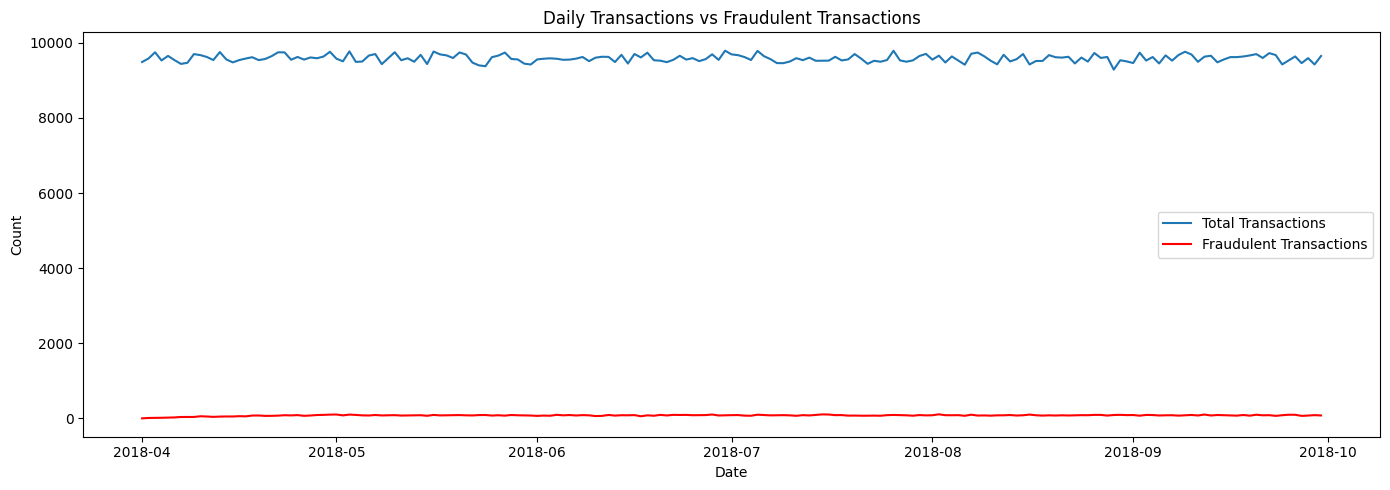

In [ ]:
# Convert to datetime
full_df['TX_DATETIME'] = pd.to_datetime(full_df['TX_DATETIME'])

# Group by date
daily_fraud_counts = full_df.groupby(full_df['TX_DATETIME'].dt.date)['TX_FRAUD'].sum()
daily_tx_counts = full_df.groupby(full_df['TX_DATETIME'].dt.date)['TX_FRAUD'].count()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(daily_tx_counts, label="Total Transactions")
plt.plot(daily_fraud_counts, label="Fraudulent Transactions", color='red')
plt.title("Daily Transactions vs Fraudulent Transactions")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


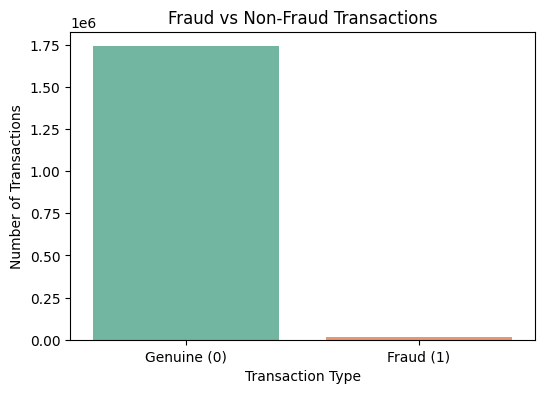

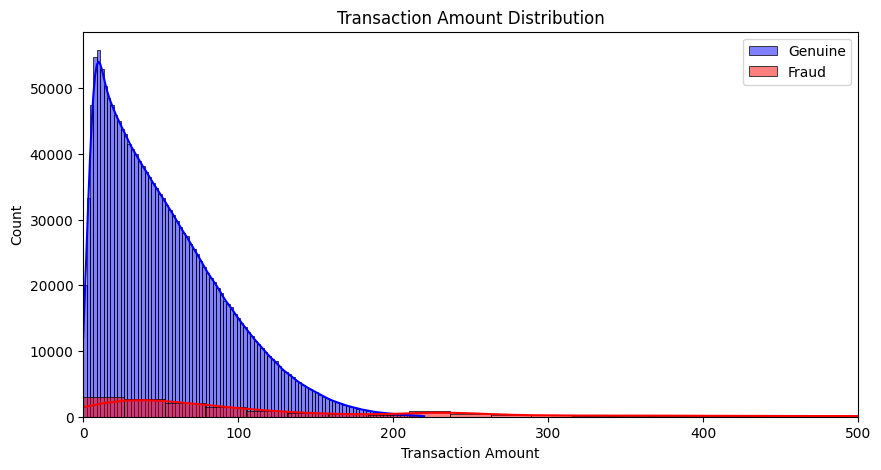

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to datetime
full_df['TX_DATETIME'] = pd.to_datetime(full_df['TX_DATETIME'])

# Fraud distribution
fraud_counts = full_df['TX_FRAUD'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="Set2")
plt.xticks([0, 1], ['Genuine (0)', 'Fraud (1)'])
plt.title("Fraud vs Non-Fraud Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Transaction Type")
plt.show()

# Amount distribution
plt.figure(figsize=(10, 5))
sns.histplot(full_df[full_df['TX_FRAUD'] == 0]['TX_AMOUNT'], bins=100, color='blue', label='Genuine', kde=True)
sns.histplot(full_df[full_df['TX_FRAUD'] == 1]['TX_AMOUNT'], bins=100, color='red', label='Fraud', kde=True)
plt.xlim(0, 500)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.legend()
plt.show()


In [ ]:
# Scenario 1
full_df['is_high_amount'] = (full_df['TX_AMOUNT'] > 220).astype(int)

# Scenario 2: Terminal fraud history (last 28 transactions)
full_df = full_df.sort_values(['TERMINAL_ID', 'TX_DATETIME'])
full_df['terminal_fraud_count_28d'] = (
    full_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .rolling(window=28, min_periods=1)
    .sum()
    .reset_index(drop=True)
)

# Scenario 3: Customer spending patterns (last 7 transactions)
full_df = full_df.sort_values(['CUSTOMER_ID', 'TX_DATETIME'])
full_df['customer_avg_amount_7d'] = (
    full_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .rolling(window=7, min_periods=1)
    .mean()
    .reset_index(drop=True)
)
full_df['customer_max_amount_7d'] = (
    full_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .rolling(window=7, min_periods=1)
    .max()
    .reset_index(drop=True)
)
full_df['is_spending_spike'] = (full_df['TX_AMOUNT'] > 3 * full_df['customer_avg_amount_7d']).astype(int)


In [ ]:
# Define features and target
feature_cols = [
    'TX_AMOUNT', 'is_high_amount', 'terminal_fraud_count_28d',
    'customer_avg_amount_7d', 'customer_max_amount_7d', 'is_spending_spike'
]
target_col = 'TX_FRAUD'

# Time-based split
full_df = full_df.sort_values('TX_DATETIME')
split_index = int(0.8 * len(full_df))

train_df = full_df.iloc[:split_index]
test_df = full_df.iloc[split_index:]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]


✅ Training completed in 94.69 seconds.

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    347681
           1       1.00      0.21      0.35      3150

    accuracy                           0.99    350831
   macro avg       0.99      0.61      0.67    350831
weighted avg       0.99      0.99      0.99    350831



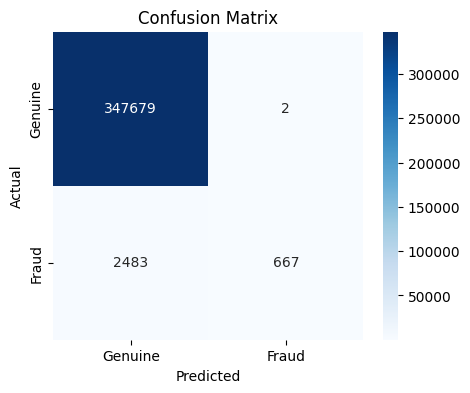

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# ⏱️ Start timer
start = time.time()

# 🔹 Optional: Use 30% of training data to speed up
sample_frac = 0.3
X_train_sample = X_train.sample(frac=sample_frac, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# 🤖 Train RandomForest
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train_sample, y_train_sample)

# ⏱️ End timer
end = time.time()
print(f"✅ Training completed in {end - start:.2f} seconds.\n")

# 🎯 Predictions
y_pred = model.predict(X_test)

# 📊 Evaluation
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# 🔍 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()